In [25]:
## Importing the necessary modules

import numpy as np
import os
import skimage.io as io
from tqdm import tqdm
import warnings
from cryptography.utils import CryptographyDeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=CryptographyDeprecationWarning)
    import paramiko
from natsort import natsorted
import scipy as sp
import time
import scipy.io as sio
import hdf5storage
from multiprocessing import TimeoutError
from multiprocessing.pool import ThreadPool as Pool
from functools import partial
import tifffile as tf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


# Address where all raw images are
data_folder = 'E:\Spandan\Kate_2024\Flat\div2\control_div2_glass_2019_01_23_C1_timelapse1_2secPerTP_5min';
file_name = 'div2cortex_C1_timelapse1_2secPerTP_5min_corrected_corey.tiff'

# Weights for temporal smoothing of the frames. Smoothing array-kernel used (by Simoncelli) 
#https://www.cns.nyu.edu/pub/eero/simoncelli94b.pdf

w1 = 0.036; w2 = 0.249; w3 = 0.431;
img = io.imread(data_folder+'\\'+file_name); 
n_frames = np.shape(img)[0];
np.shape(img)


## If there is an image sequence rather than a single .TIF file, uncomment the section below

# file_list = natsorted(os.listdir(data_folder))    # sort the image files numerically by frame-index
# n_frames = len(file_list);

# img1 = io.imread(str(data_folder+'\\'+file_list[0]))   # Read the shape of the first frame

# # Preallocating memory for saving all the image frames in single matrix
# img = np.zeros([n_frames,np.shape(img1)[0],np.shape(img1)[1]],dtype=np.float32)
# for k in tqdm(range(n_frames)):
#     img[k,:,:] = io.imread(str(data_folder+'\\'+file_list[k]))

(151, 512, 512)

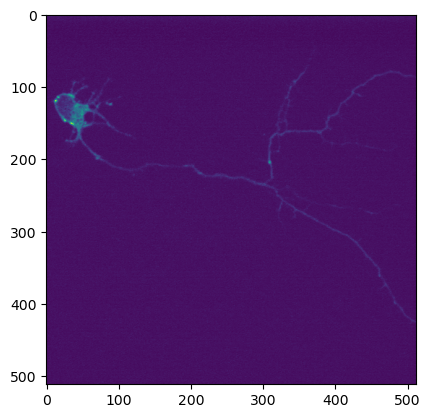

In [26]:
plt.imshow(img[0,:,:])   # check out the first frame of the raw movie

Run time = 0.3879890441894531 s


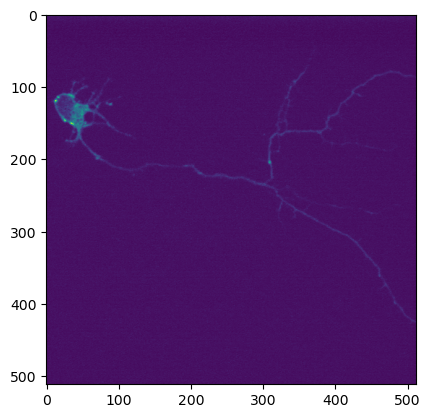

In [27]:
start = time.time()

# smoothing the image frames
smo_im = w1*img[0:-4] + w2*img[1:-3] + w3*img[2:-2] + w2*img[3:-1] + w1*img[4:]
fin_im = np.concatenate((img[0:1],img[1:2],smo_im,img[-2:-1],img[-1:]),axis = 0)   # padding the bordering time-frames

end = time.time(); print('Run time = '+str(end-start)+' s')

plt.imshow(fin_im[0,:,:])    # check out the first frame of the smoothened movie

In [28]:
# Lucas-Kanade method for Optical Flow
# INPUTS: 

#k: Timeframe index, input_image: temporally smoothed movie
#sig: Spread of the Gaussian weights around a pixel, #thresh: Threshold for reliability score

# OUTPUTS (stored in a data file): 
#vx: x-velocity, vy: y-velocity, reliabMat: reliability score for velocities calculated at a pixel (higher the better)

def LKxOptFlow(k,input_image,sig,thresh):

    img1 = input_image[k]             # Load temporally smoothed frame-1
    img2 = input_image[k+1]         # Load temporally smoothed frame-2
    
    ddy = np.gradient(img1,axis=0,edge_order=2)
    ddx = np.gradient(img1,axis=1,edge_order=2)
    dt = img2 - img1

    ddy = ddy.astype(np.float32); ddx = ddx.astype(np.float32); dt = dt.astype(np.float32); 

    wdx2 = sp.ndimage.gaussian_filter(ddx**2, sig, mode='nearest')
    wdy2 = sp.ndimage.gaussian_filter(ddy**2, sig, mode='nearest')
    wdxy = sp.ndimage.gaussian_filter(ddx*ddy, sig, mode='nearest')
    wdtx = sp.ndimage.gaussian_filter(ddx*dt, sig, mode='nearest')
    wdty = sp.ndimage.gaussian_filter(ddy*dt, sig, mode='nearest')

    trace = wdx2 + wdy2; determinant=(wdx2*wdy2)-(wdxy**2); 
    eps = 1e-6
    
    e1=(trace + np.sqrt(eps + trace**2 - 4*determinant))/2;
    e2=(trace - np.sqrt(eps + trace**2 - 4*determinant))/2;
    reliabMat = np.minimum(e1,e2);
    
    vx = ((determinant + eps)**(-1))*((wdxy*wdty)-(wdy2*wdtx));
    vy = ((determinant + eps)**(-1))*((wdxy*wdtx)-(wdx2*wdty));
    
    vx = vx*(reliabMat > thresh);
    vy = vy*(reliabMat > thresh);
    
#     np.savez(save_path+'/{}.npz'.format(k),vx = vx,vy = vy,rel=reliabMat)   # to save as numpy data files
    sio.savemat(save_path+'\\{}.mat'.format(k),{'vx':vx,'vy':vy,'rel':reliabMat},do_compression=False) # to save as .MAT files
    return [0]


save_path = data_folder+'\\Op_flow_corey'                 # Create a local folder for storing OF results
os.makedirs(save_path, exist_ok=True);

numProcessors = 16   # maybe change it to 8 (but that's it)
pool = Pool(processes=numProcessors)
    
print('Post-processing in parallel with '+str(numProcessors)+' processors')

#store start time
stopwatchStart = time.time()
[temp] =zip(*pool.map(partial(LKxOptFlow, input_image = fin_im, sig = 2, thresh = 0.1), range(n_frames-1)))
  
print('Wall time = '+str(np.round(time.time() - stopwatchStart,2))+' s')

print('Parallel post processing complete, switching to serial')
pool.close()

%reset

Post-processing in parallel with 16 processors
Wall time = 2.3 s
Parallel post processing complete, switching to serial
Once deleted, variables cannot be recovered. Proceed (y/[n])? y
